In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=1, aug_alpha=True),LossTracker(),SaveBest('weights/best_ie1la.h5'),EarlyStopping(10)])

1: Train=523.137407836914 Valid=535.9689904785156
2: Train=508.97295318603517 Valid=520.7807879638672
3: Train=483.7596078491211 Valid=479.2770678710938
4: Train=449.36045440673826 Valid=441.9106335449219
5: Train=413.6840969848633 Valid=403.51079528808594
6: Train=386.46564392089846 Valid=382.16052734375
7: Train=370.19470672607423 Valid=369.6201867675781
8: Train=359.5344812011719 Valid=359.3630670166016
9: Train=350.6609252929687 Valid=350.09847351074217
10: Train=340.18103668212893 Valid=342.08044921875
11: Train=332.2899395751953 Valid=337.4347174072266
12: Train=331.9667855834961 Valid=333.18380249023437
13: Train=327.9105651855469 Valid=330.05403686523437
14: Train=324.5357815551758 Valid=329.8756182861328
15: Train=323.61119171142576 Valid=325.27172607421875
16: Train=319.45577117919925 Valid=323.0718878173828
17: Train=318.12515716552736 Valid=323.93242126464844
18: Train=319.1751480102539 Valid=320.6639782714844
19: Train=313.3166424560547 Valid=319.74595825195314
20: Train=3

In [8]:
model.save('weights/Inferno_Test_exact_bm1la.h5')

In [9]:
model.load('weights/Inferno_Test_exact_bm1la.h5')

# Results

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,5,1.0
1,6,1.0
2,9,1.0
3,9,1.0
4,9,1.0


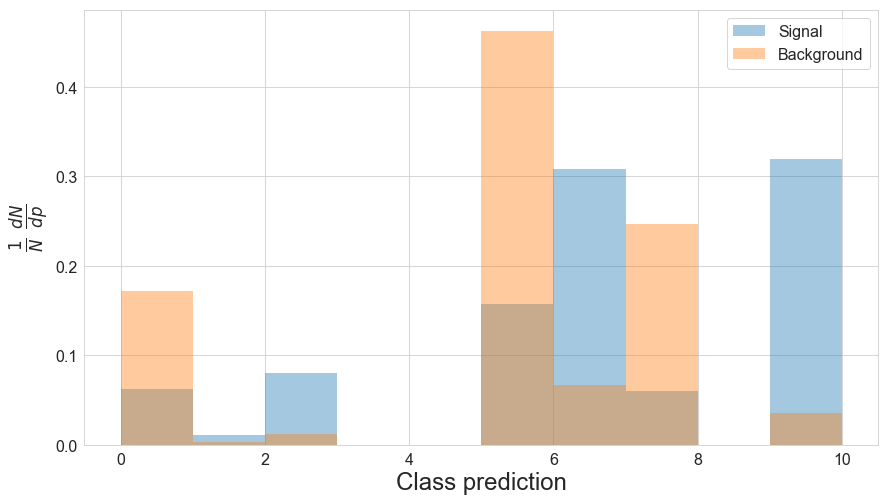

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,6,1.0,6
2,9,1.0,9
3,9,1.0,9
4,9,1.0,9


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([6.2016e-02, 1.1128e-02, 8.0554e-02, 2.0000e-13, 2.0000e-13, 1.5787e-01,
         3.0860e-01, 5.9960e-02, 2.0000e-13, 3.1987e-01]),
 tensor([1.7163e-01, 3.3740e-03, 1.2632e-02, 2.0000e-13, 2.0000e-13, 4.6304e-01,
         6.7102e-02, 2.4693e-01, 2.0000e-13, 3.5294e-02]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([1.7473e+02, 3.9304e+00, 1.6660e+01, 2.1000e-10, 2.1000e-10, 4.7094e+02,
         8.2532e+01, 2.4992e+02, 2.1000e-10, 5.1288e+01]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([22.98763084, 22.86037254, 22.73774338, 22.62062454, 22.50830841,
       22.40044022, 22.29801178, 22.20008278, 22.10685349, 22.01820374,
       21.934618  , 21.85526466, 21.78011703, 21.70999146, 21.64382172,
       21.58212471, 21.52505302, 21.47185326, 21.42284775, 21.37805939,
       21.33749008, 21.30104446, 21.26844788, 21.23983383, 21.21549416,
       21.19430542, 21.17778015, 21.16499138, 21.15551567, 21.14981842,
       21.14795876, 21.14973831, 21.15540123, 21.16412926, 21.17684174,
       21.1930542 , 21.21257019, 21.2358551 , 21.2623024 , 21.29209137,
       21.32500648, 21.36156464, 21.40137863, 21.44437027, 21.49051857,
       21.53955841, 21.59239578, 21.64834404, 21.70677185, 21.76871872,
       21.83370781, 21.90140915, 21.9724865 , 22.04641342, 22.12302589,
       22.20286751, 22.28570175, 22.37091446, 22.45935631, 22.55060577,
       22.64416122])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

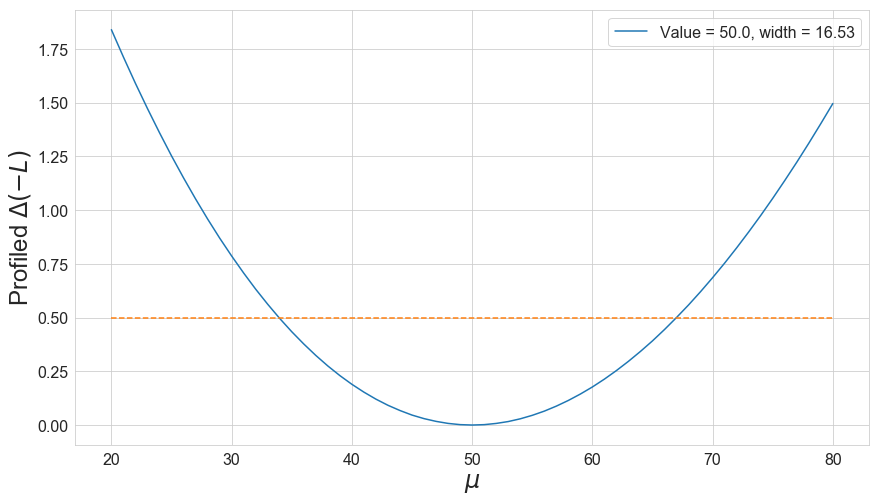

In [23]:
plot_likelihood(y-y.min())

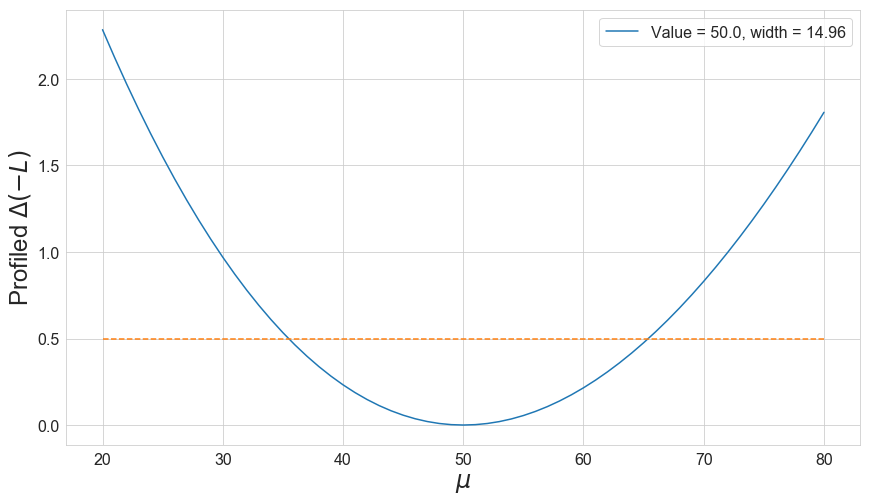

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [25]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [26]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,6,1.0,6,6,6,6,6,6,6,6,6,6,6
2,9,1.0,9,9,9,9,9,9,9,9,9,9,9
3,9,1.0,9,9,9,9,9,9,9,9,9,9,9
4,9,1.0,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5,0.0,5,5,5,5,5,5,5,5,5,5,5
999996,5,0.0,5,5,5,5,5,5,5,5,5,5,5
999997,5,0.0,5,5,5,5,5,5,5,5,5,5,5
999998,5,0.0,5,5,5,5,5,5,5,5,5,5,5


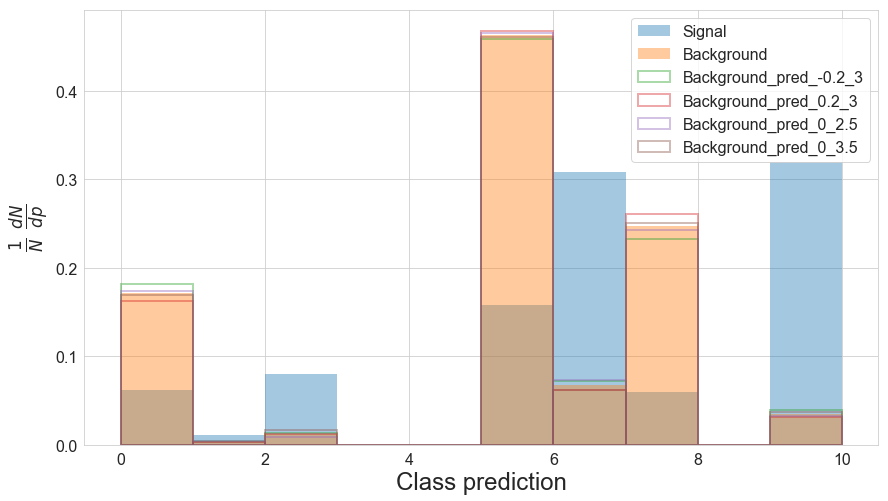

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([1.8359e-01, 4.2760e-03, 9.3340e-03, 2.0000e-13, 2.0000e-13, 4.6025e-01,
        7.8132e-02, 2.2834e-01, 2.0000e-13, 3.6084e-02])
tensor([1.8128e-01, 3.7980e-03, 1.3084e-02, 2.0000e-13, 2.0000e-13, 4.5816e-01,
        7.2474e-02, 2.3219e-01, 2.0000e-13, 3.9014e-02])
tensor([1.7910e-01, 3.4120e-03, 1.7308e-02, 2.0000e-13, 2.0000e-13, 4.5595e-01,
        6.7646e-02, 2.3536e-01, 2.0000e-13, 4.1222e-02])
tensor([1.7394e-01, 3.8520e-03, 8.8820e-03, 2.0000e-13, 2.0000e-13, 4.6513e-01,
        7.2760e-02, 2.4308e-01, 2.0000e-13, 3.2364e-02])
tensor([1.7163e-01, 3.3740e-03, 1.2632e-02, 2.0000e-13, 2.0000e-13, 4.6304e-01,
        6.7102e-02, 2.4693e-01, 2.0000e-13, 3.5294e-02])
tensor([1.6945e-01, 2.9880e-03, 1.6856e-02, 2.0000e-13, 2.0000e-13, 4.6083e-01,
        6.2274e-02, 2.5010e-01, 2.0000e-13, 3.7502e-02])
tensor([1.6433e-01, 3.5000e-03, 8.5040e-03, 2.0000e-13, 2.0000e-13, 4.7015e-01,
        6.7798e-02, 2.5724e-01, 2.0000e-13, 2.8478e-02])
tensor([1.6202e-01, 3.0220e-03, 1.2254e-0

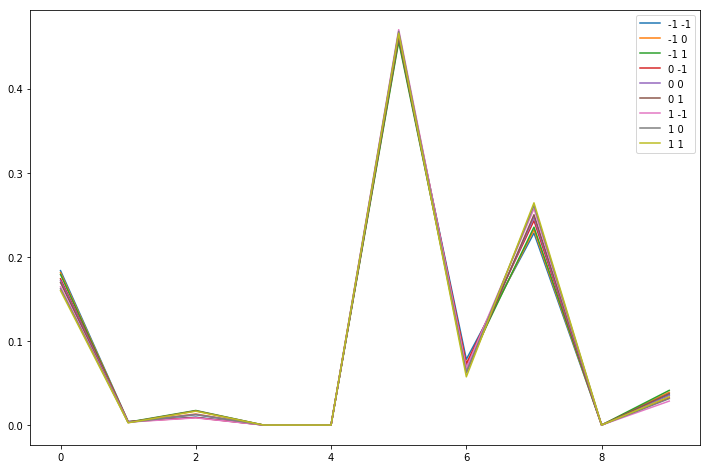

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

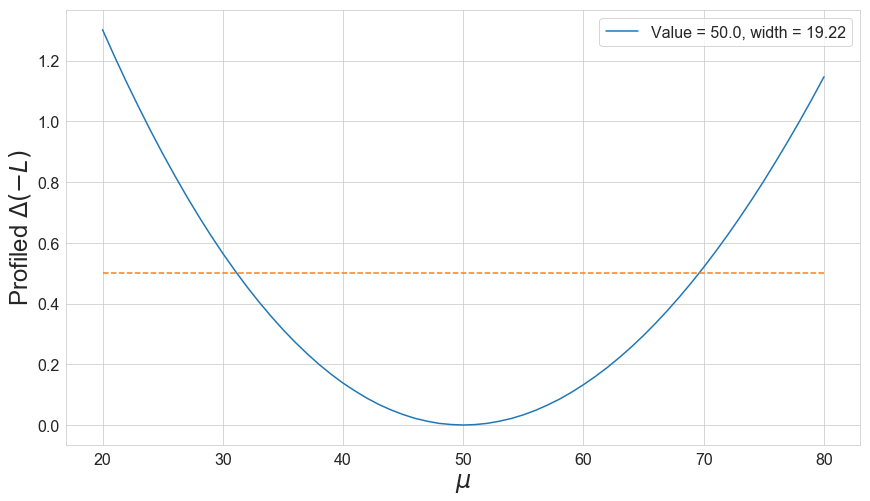

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

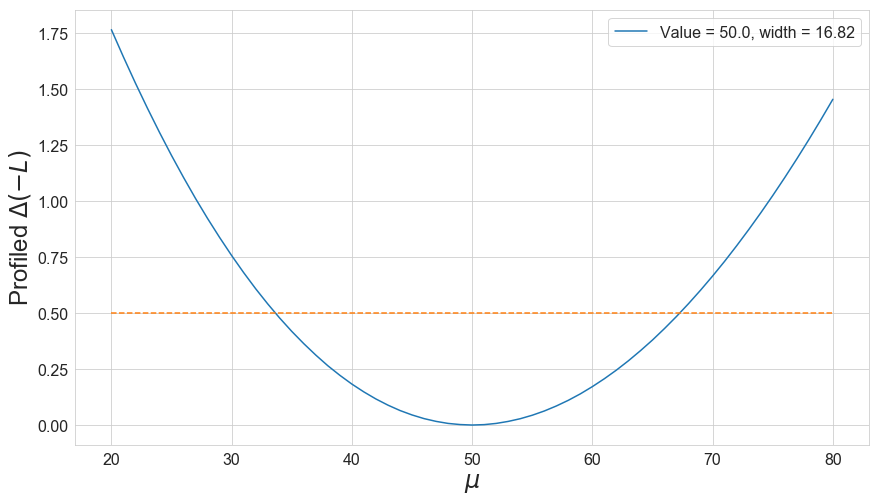

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

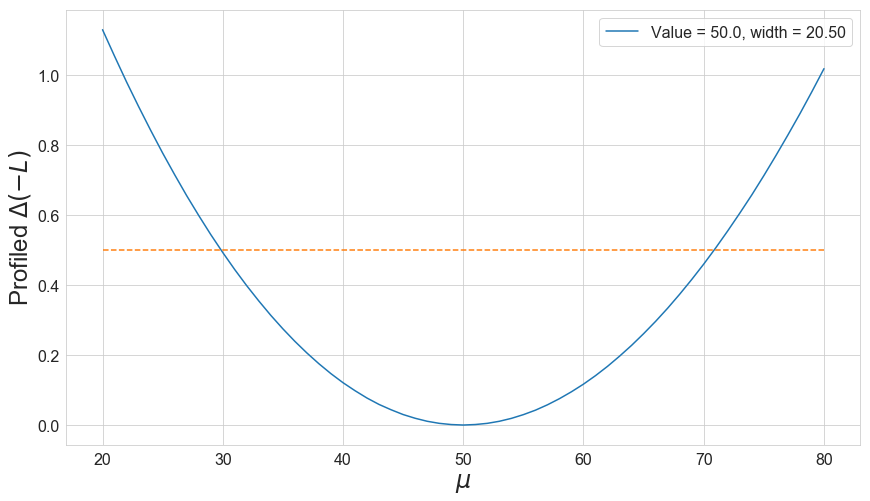

In [42]:
plot_likelihood(nll-nll.min())